# Vegetation Phenology using Sentinel-1 and Sentinel-2 

* **Products used:** 
[s1_rtc](),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series.](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook  gives an example of using Sentinel-1 analysis ready data (ARD) radar backscatter (Gamma nought) for exploring annual vegetation dynamics by using **Radar Vegetation Index(RVI)**. RVI is a function of incidence angle since the path length through the vegetation canopy will increase as the incidence angle increases; however, the current analysis focuses on a single incidence angle. The RVI has been proposed as a method for monitoring the level of vegetation growth, particularly when time series data are available.
RVI generally ranges between 0 and 1 and is a measure of the randomness of the scattering. RVI is near zero for a smooth bare surface and increases as a crop grows (up to a point in the growth cycle).

This notebook also demonstrates how to calculate vegetation phenology statistics using the DE Africa function [xr_phenology](../Scripts/deafrica_temporal_statistics.py).  To detect changes in plant life for Sentinel-2, the script uses the **Normalized Difference Vegetation Index (NDVI)** which is common proxy for vegetation growth and health.

Sentinel-1 data are indexed as product "S1_rtc" for radar backscatter.The dual-pol Radar Vegetation Index (RVI) from Sentinel-1 will be compared  with Sentinel-2 NDVI for multi-temporal trends due to their relationship with vegetaton biomass. Monthly means for the RVI will be generated and saved as a GeoTiff. 

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load Sentinel-1 radar backscatter and cloud-masked Sentinel-2 data for an area of interest.
2. Apply speckle filtering 
3. Calculate Vegetation Indices NDVI and RVI
4. Compare RVI and NDVI timeseries
5. Generate a zonal time series of vegetation health
6. Complete and smooth the vegetation timeseries to remove gaps and noise
7. Calculate phenology statistics on a simple 1D vegetation time series
8. Calculate per-pixel phenology statistics
9. Save results to Geotiff files
***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

import deafrica_tools.temporal as ts
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb


from datacube.utils.aws import configure_s3_access
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.classification import HiddenPrints
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. For an introduction to using Dask with Digital Earth Africa, see the Dask notebook.

In [2]:
create_local_dask_cluster(spare_mem='1Gb')

Client Scheduler: tcp://127.0.0.1:40607 Dashboard: /user/neginm/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 106.37 GB


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `product`: The satellite product to load. Either Sentinel-2: `'s2_l2a'`, or Sentinel-1: `'s1_rtc'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2017-01-01', '2019-12-30')`).
* `min_gooddata`: the fraction of good data (not cloudy) a scene must have before it is returned as a dataset 
* `resolution`: The pixel resolution, in metres, of the returned dataset
* `dask_chunks`: The size, in number of pixel, for the dask chunks on each dimension.

In [3]:
#Set the vegetation proxy to use 
veg_proxy1 = 'NDVI'
veg_proxy2 = 'EVI'
#Set the product to use 
productA = 's2_l2a'
productB = 's1_rtc'
#set the location 
#Aviv Coffee Farm, Tanzania
lat = -10.6979 
lon = 35.2635
lon_buffer = 0.003
lat_buffer = 0.003
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)
# Set the range of dates for the analysis
time_range = ('2020-11-03','2021-05-05')
min_gooddata = 0.15
resolution = (-20,20)
dask_chunks = {'x':750, 'y':750}


### Connect to the datacube

Connect to the datacube so we can access DE Africa data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [4]:
dc = datacube.Datacube(app='Vegetation_phenology_S1')

In [5]:
dc.list_products().loc[dc.list_products()['description'].str.contains('radar')]

,name,description,lat,region_code,format,platform,product_family,instrument,product_type,dataset_maturity,lon,time,label,creation_time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,,,,
3,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,None,NaN,None,None,NaN,None,NaN,NaN,None,None,None,None,NaN,NaN,NaN,NaN


## Load Sentinel-1 radar backscatter data and cloud-masked Sentinel-2 

The first step is to load Sentinel-1 radar backscatter data for the specified area of interest and time range. 
`dc.load()` function is used to return a time series of satellite images. The returned xarray.Dataset dataset will contain analysis ready images over agriculture field in part of Tanzania.

In [6]:
# Create a reusable query for Sentinel-2
query_S2 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red','blue','nir','green','swir_1','SCL'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-2
ds_S2 = dc.load(product=productA,
             **query_S2)

print(ds_S2)

<xarray.Dataset>
Dimensions:      (time: 36, x: 30, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 2020-11-09T08:03:00 ... 2021-05-03T08:...
  * y            (y) float64 -1.357e+06 -1.357e+06 ... -1.357e+06 -1.357e+06
  * x            (x) float64 3.402e+06 3.402e+06 ... 3.403e+06 3.403e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 375 256 192 185 130 ... 5484 5972 6044 6200
    blue         (time, y, x) uint16 134 136 117 131 60 ... 6188 6584 6768 6896
    nir          (time, y, x) uint16 926 1296 912 770 ... 6076 6456 6512 6552
    green        (time, y, x) uint16 255 260 196 167 153 ... 5820 6300 6364 6524
    swir_1       (time, y, x) uint16 897 1028 746 595 ... 5055 5295 5464 5523
    SCL          (time, y, x) uint8 4 4 4 3 3 3 2 2 2 2 ... 9 9 9 9 9 9 9 9 9 9
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [7]:
# Create a reusable query for Sentinel-1
query_S1 = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['vv', 'vh', 'mask','angle'],
    'resolution': resolution,
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# # Load available data from Sentinel-1
ds_S1 = dc.load(product=productB,
             **query_S1)

#identify and remove the scenes that are mostly null values 
No_px=len(ds_S1.x)*len(ds_S1.y)
valid=ds_S1.where(ds_S1.vv!=0).where(ds_S1.vh!=0).count(dim=('x','y'))
good=(valid.vh/No_px)>0.5
S1 = ds_S1.sel(time=good)

#creation of a new band (VH/VV=vhvv) for RGB display 
S1['vhvv'] = S1.vh.where(S1.mask==1) / S1.vv.where(S1.mask==1)
print(S1)

<xarray.Dataset>
Dimensions:      (time: 8, x: 30, y: 38)
Coordinates:
  * time         (time) datetime64[ns] 2020-11-04T16:02:13.386534 ... 2020-12...
  * y            (y) float64 -1.357e+06 -1.357e+06 ... -1.357e+06 -1.357e+06
  * x            (x) float64 3.402e+06 3.402e+06 ... 3.403e+06 3.403e+06
    spatial_ref  int32 6933
Data variables:
    vv           (time, y, x) float32 0.09164392 0.09240154 ... 0.24822614
    vh           (time, y, x) float32 0.041287504 0.03165331 ... 0.020643808
    mask         (time, y, x) uint8 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    angle        (time, y, x) uint8 37 36 34 33 34 35 35 ... 34 34 34 34 34 33
    vhvv         (time, y, x) float32 0.45052093 0.3425626 ... 0.083165325
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [8]:
display_map(x=lon_range, y=lat_range)

## Apply speckle filtering

The distortion you're seeing in Sentinel-1 imagery is a type of noise known as speckle, which gives the images a grainy appearence.
If we want to be able to easily decide whether any particular pixel is water or land, we need to reduce the chance of misinterpreting a water pixel as a land pixel due to the noise.

Speckle can be removed through filtering.
If interested, you can find a technical introduction to speckle filtering [here](https://earth.esa.int/documents/653194/656796/Speckle_Filtering.pdf).
For now, it is enough to know that we can filter the data using the Python function defined in the next cell:

In [9]:
def lee_filter(da, size):
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

Now that we've defined the filter, we can run it on the VV and VH data. You might have noticed that the function takes a size argument. This will change how blurred the image becomes after smoothing. We've picked a default value for this analysis, but you can experiement with this if you're interested.

In [10]:
# Set any null values to 0 before applying the filter to prevent issues
S1_filled = S1.where(~S1.isnull(), 0)

In [11]:
# Create new bands in dataset corresponding to filtered VV and VH data
filtered_vv= S1_filled.vv.groupby("time").apply(lee_filter, size=7)
filtered_vh= S1_filled.vh.groupby("time").apply(lee_filter, size=7)

In [12]:
#create smoothed dataset and assign attributes 
nodata_mask = S1.isnull().to_array().any(axis=0)
smoothed = filtered_vv.to_dataset(name='vv')
smoothed['vh'] = filtered_vh
smoothed = smoothed.where(~nodata_mask)
smoothed.assign_attrs(S1.attrs);

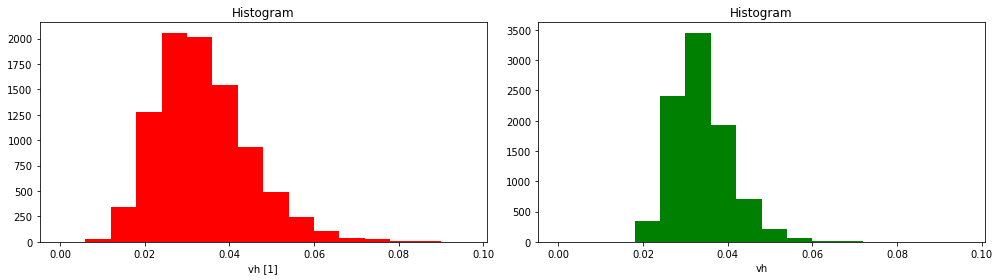

In [13]:
#plotting each polorisation bands following converting to dB values 
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
S1.vh.where(S1.mask==1).plot.hist(ax=ax[0],bins=np.arange(0,0.1,0.006), facecolor='red')
smoothed.vh.plot.hist(ax=ax[1],bins=np.arange(0,0.1,0.006), facecolor='green')
plt.tight_layout()

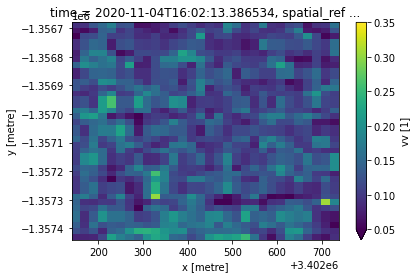

In [14]:
S1.vv.isel(time=0).plot(vmin=0.05,vmax=0.35,robust=True)

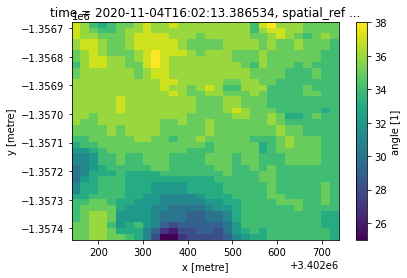

In [15]:
S1.angle.isel(time=0).plot()

**Once the load is complete**, we can plot some of the images as as a true-colour composite image using the `rgb` function.  

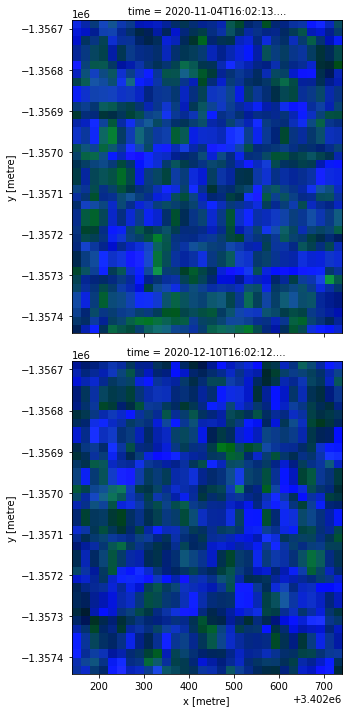

In [16]:
rgb(S1.where(ds_S1.mask==1), bands=['vh','vv','vhvv'], index=[0,5], col_wrap=1, size=5)

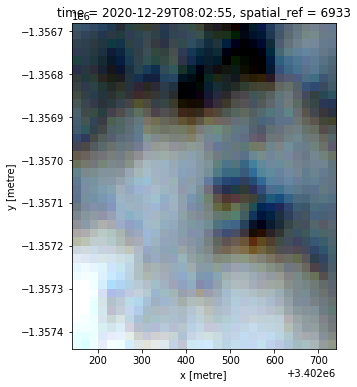

In [17]:
rgb(ds_S2, index=[10], col_wrap=1, size=6)

## Cloud Buffering for Sentinel-2

The cloud masking data for Sentinel-2 is less than perfect, and missed cloud in the data greatly impacts vegetation  calculations. Below we will buffer the cloud-masking bands in an attempt to improve the masking of poor quality data.

In [18]:
#check with Fang/chad this part that is not working 
# import odc.algo

# #Extract boolean mask

# mask = odc.algo.enum_to_bool(ds_S2.SCL, 
#                              categories=['cloud shadows','cloud medium probability',
#                                          'cloud high probability', 'thin cirrus'])
                             
# # # Close mask to remove small holes in cloud, open mask to remove narrow false positive cloud, then dilate
# # mask = odc.algo.binary_closing(mask, 2)
# # mask_cleaned = odc.algo.mask_cleanup(mask, r=(2, 10))

# # # Add new mask as nodata pixels
# # ds_S2 = odc.algo.erase_bad(ds_S2, mask_cleaned)

## Mask the Sentinel-2 data with shape 

We can create a mask layer out of our shapefile in order to mask the areas with Water for intance to remove the impact on our analysis.

In [19]:
# #create mask
# mask = xr_rasterize(gdf,ds_S2)

# #mask data
# ds_S2 = ds_S2.where(mask)

## Compute band indices

This study measures the presence of vegetation through the `normalised difference vegetation index (NDVI)` and the `Radar Vegetation Index(RVI)`.
The index for optical dataset i.e. Sentinel-2 is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Radar Vegetation Index requires the `VH` and `VV` polarisation bands.
The formula is

$$
\begin{aligned}
\text{RVI} & = \frac{4 \times \text{VH}}{(\text{VV} + \text{VH})} \\
\end{aligned}
$$

The normalised difference vegetation index is available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [deafrica_bandindices.py](../Scripts/deafrica_bandindices.py).
Here, we use `collection='s2'` since we're working with Sentinel-2 data.

In [20]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
#ds_S2 = calculate_indices(ds_S2, index=veg_proxy1, collection='s2')

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

In [21]:
#calculate the Radar Vegetation Index and add it to the smoothed loaded S1 dataset 
smoothed['RVI'] = 4 *smoothed.vh/(smoothed.vv + smoothed.vh)

In [22]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy1,'NDVI'], collection='s2')
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy2,'EVI'], collection='s2')
ds_S2 = calculate_indices(ds_S2, index=[veg_proxy2,'MNDWI'], collection='s2')
#drop bands that are no longer needed (save memory)
ds_S2 = ds_S2.drop(['red','green','nir','blue','swir_1','SCL'])
#convert to float 32 to conserve memory
ds_S2=ds_S2.astype(np.float32)

## Prepare data for analysis

Remove any NaN or infinite values, mask water, remove any outliers in the vegetation index.  We then reduce the data to a 1D timeseries by calculating the mean across the x and y dimensions. We will also 'compute' the data on the dask cluster to speed up calculations later on. This step will take 5-10mins to run since we are now computing everything that came before.

In [23]:
# remove any infinite values
ds_S2 = ds_S2.where(xr.ufuncs.isfinite(ds_S2))

# mask water
ds_S2 = ds_S2.where(ds_S2.MNDWI < 0)

#remove outliers (if EVI greater than 1.0, set to NaN) 
ds_S2['EVI'] = xr.where(ds_S2['EVI']>1.0, np.nan, ds_S2['EVI'])

# create 1D line plots
veg = ds_S2[veg_proxy1].mean(['x', 'y']).compute()

## Smooth and interpolate time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will smooth and interpolate the data to ensure we working with a consistent time-series.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps

In [24]:
resample_period='2W'
window=4

veg_smooth=veg.resample(time=resample_period, label='left', loffset='1W').median().rolling(time=window, min_periods=1).mean()

## Plot the entire time-series

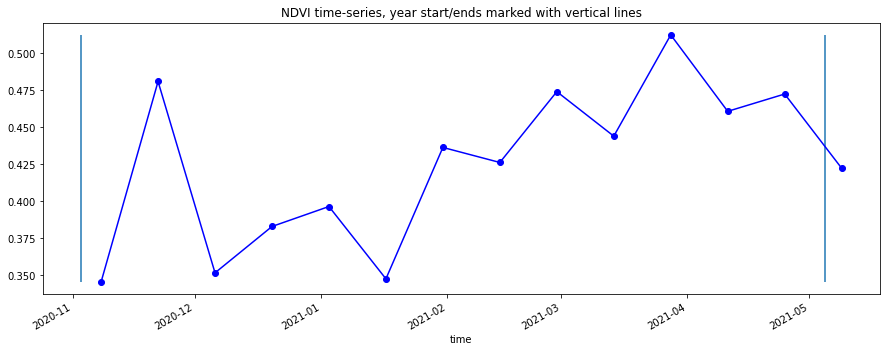

In [25]:
veg_smooth.plot.line('b-o', figsize=(15,5))
_max=veg_smooth.max()
_min=veg_smooth.min()
plt.vlines(np.datetime64('2020-11-03'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-05-05'), ymin=_min, ymax=_max)
plt.title(veg_proxy1+' time-series, year start/ends marked with vertical lines');

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


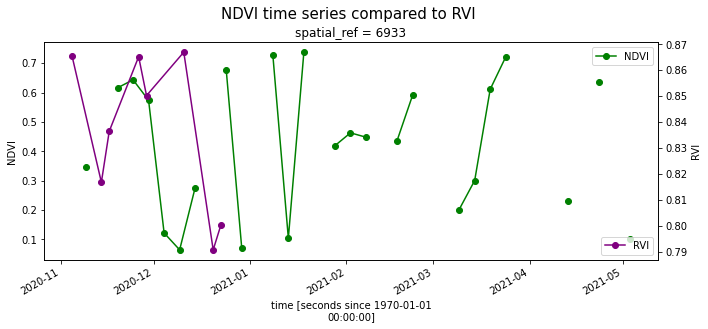

In [26]:
ndvi = ds_S2.NDVI.mean(['x', 'y'])
rvi = smoothed.RVI.mean(['x', 'y'])
fig, ax = plt.subplots(figsize=(11, 4))

ndvi.plot.line('b-o',ax=ax, color='green', label='NDVI')
ax.set_title('NDVI time series compared to RVI \n', fontsize="15", color="black")

ax2 = ax.twinx()
rvi.plot.line('b-o', ax=ax2, color='purple', label='RVI');

leg1 = ax.legend(loc='upper right',frameon=True)
leg2 = ax2.legend(loc='lower right',frameon=True)

## Compute basic phenology statistics

Below we specify the statistics to calculate, and the method we'll use for determining the statistics. 

The statistics acronyms are as follows:
* `SOS` - Day of year of Start of Season
* `vSOS` - value at Start of Season
* `POS` - Day of year of Peak of Season
* `vPOS` - value at Peak of Season
* `EOS` - Day of year of End of Season
* `vEOS` - value at End of Season
* `Trough` - minimum value across the dataset timeframe
* `LOS` - Length of Season, measured in days
* `AOS` - Amplitude of Season, the difference between `vPOS` and `Trough`
* `ROG` - Rate of Greening, rate of change from start to peak of season
* `ROS` - Rate of Senescing, rae of change from peak to end of season

Options are 'first' & 'median' for `method_sos`, and 'last' & 'median' for `method_eos`.

    method_sos : str 
            If 'first' then vSOS is estimated as the first positive 
            slope on the greening side of the curve. If 'median',
            then vSOS is estimated as the median value of the postive
            slopes on the greening side of the curve.

    method_eos : str
            If 'last' then vEOS is estimated as the last negative slope
            on the senescing side of the curve. If 'median', then vEOS is
            estimated as the 'median' value of the negative slopes on the
            senescing side of the curve.

In [27]:
basic_pheno_stats = ['SOS','vSOS','POS','vPOS','EOS','vEOS','Trough','LOS','AOS','ROG','ROS']
method_sos = 'first'
method_eos = 'last'

In [28]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    print(year)
    #select year
    da = dict(years)[year]
    
    #calculate stats
    with HiddenPrints():
        stats=ts.xr_phenology(
                da,
                method_sos=method_sos,
                method_eos=method_eos,
                stats=basic_pheno_stats,
                complete=None,
                smoothing=None,
                    )
    #add results to dict    
    pheno_results[str(year)] = stats

2020
2021


### Re-mask data

The phenology code has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions over water and outside the mask. We will therefore have to mask the data again.

In [29]:
# #mask with polygon
# stats = stats.where(mask)

# #mask with water-mask
# stats = stats.where(water_mask)

In [30]:
for key,value in pheno_results.items():
    print('Year: ' +key)
    for b in value.data_vars:
        print("   "+b+": ", round(float(value[b].values),4))

        #pheno_results[key].drop('spatial_ref').assign_coords({'index':[key]}).to_dataframe().to_csv('results/'+key+'_phenology.csv')

Year: 2020
   SOS:  313.0
   vSOS:  0.3454
   POS:  327.0
   vPOS:  0.4807
   EOS:  341.0
   vEOS:  0.3516
   Trough:  0.3454
   LOS:  28.0
   AOS:  0.1353
   ROG:  0.0097
   ROS:  -0.0092
Year: 2021
   SOS:  17.0
   vSOS:  0.3475
   POS:  87.0
   vPOS:  0.5121
   EOS:  129.0
   vEOS:  0.4221
   Trough:  0.3475
   LOS:  112.0
   AOS:  0.1646
   ROG:  0.0024
   ROS:  -0.0021


Text(0.5, 1.0, 'Yearly NDVI')

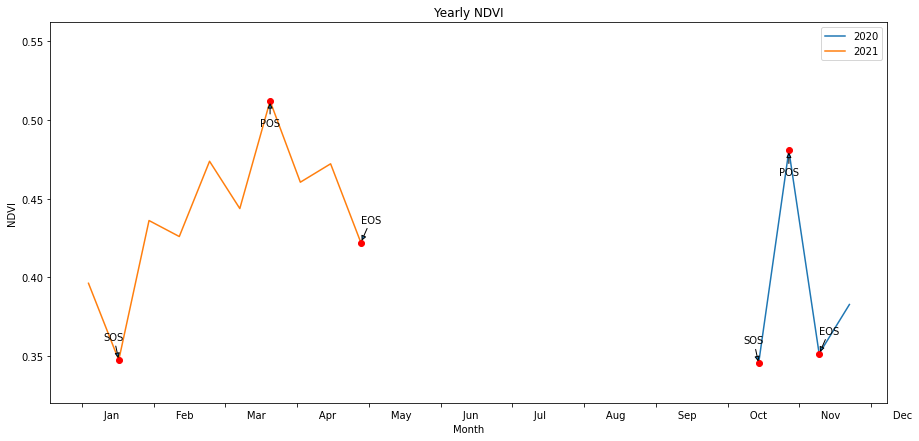

In [31]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
for year, y in zip(years, years_int):
    #grab tall the values we need for plotting
    eos = pheno_results[str(y)].EOS.values
    sos = pheno_results[str(y)].SOS.values
    pos = pheno_results[str(y)].POS.values

    veos = pheno_results[str(y)].vEOS.values
    vsos = pheno_results[str(y)].vSOS.values
    vpos = pheno_results[str(y)].vPOS.values
    
    #create plot
    #the groupby and mean below doesn't actually do anything, expect allow
    #the plots to be on the same x-axis. i.e. veg-data isn't modified, just time units
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0])

    #add start of season
    ax.plot(sos, vsos, 'or')
    ax.annotate('SOS',
                xy=(sos, vsos),
                xytext=(-15, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add end of season
    ax.plot(eos, veos, 'or')
    ax.annotate('EOS',
                xy=(eos, veos),
                xytext=(0, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add peak of season
    ax.plot(pos, vpos, 'or')
    ax.annotate('POS',
                xy=(pos, vpos),
                xytext=(-10, -25),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

ax.legend()
plt.ylim(_min-0.025,_max.values+0.05)
month_abbr=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
new_m=[]
for m in month_abbr:
    new_m.append('       %s'%m) #Add spaces before the month name
plt.xticks(np.linspace(0,365,12), new_m, horizontalalignment='left')
plt.xlabel('Month')
plt.ylabel(veg_proxy1)
plt.title('Yearly '+ veg_proxy1)
#plt.savefig('results/yearly_phenology_plot.png');

The basic phenology statistics are summarised in a more readable format below. We can compare the statistics at a high level. Further analysis should be conducted using the .csv exports in the `/results` folder.

In [32]:
print(xr.concat([pheno_results[str(year)] for year in years_int], dim=pd.Index(years_int, name='time')).to_dataframe().drop(columns=['spatial_ref']).T.to_string())

time          2020        2021
SOS     313.000000   17.000000
vSOS      0.345398    0.347515
POS     327.000000   87.000000
vPOS      0.480667    0.512112
EOS     341.000000  129.000000
vEOS      0.351562    0.422145
Trough    0.345398    0.347515
LOS      28.000000  112.000000
AOS       0.135269    0.164597
ROG       0.009662    0.002351
ROS      -0.009222   -0.002142


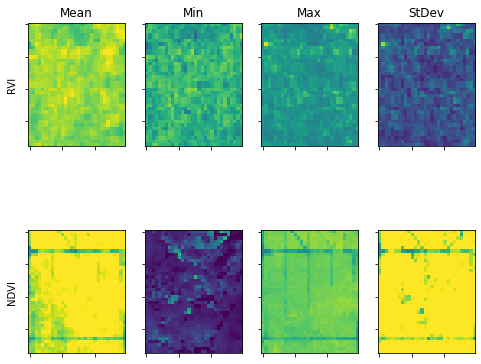

In [33]:
RVI_mean = np.flip(smoothed.RVI.mean(dim='time'))
RVI_min = np.flip(smoothed.RVI.min(dim='time'))
RVI_max = np.flip(smoothed.RVI.max(dim='time'))
RVI_std = np.flip(smoothed.RVI.std(dim='time'))
NDVI_mean = np.flip(ds_S2.NDVI.mean(dim='time'))
NDVI_min = np.flip(ds_S2.NDVI.min(dim='time'))
NDVI_max = np.flip(ds_S2.NDVI.max(dim='time'))
NDVI_std = np.flip(ds_S2.NDVI.std(dim='time'))

fix, ax = plt.subplots(2,4, figsize=(8,7))
ax[0,0].imshow(RVI_mean, clim=(0,1.0))
ax[0,0].set_title('Mean')
ax[0,0].set_ylabel('RVI')
ax[0,0].set_xticklabels([])
ax[0,0].set_yticklabels([])
ax[0,1].imshow(RVI_min, clim=(0,1.0))
ax[0,1].set_title('Min')
ax[0,1].set_xticklabels([])
ax[0,1].set_yticklabels([])
ax[0,2].imshow(RVI_max, clim=(0,2.0))
ax[0,2].set_title('Max')
ax[0,2].set_xticklabels([])
ax[0,2].set_yticklabels([])
ax[0,3].imshow(RVI_std, clim=(0,0.5))
ax[0,3].set_title('StDev')
ax[0,3].set_xticklabels([])
ax[0,3].set_yticklabels([])
ax[1,0].imshow(NDVI_mean, clim=(0.1,0.5))
ax[1,0].set_ylabel('NDVI')
ax[1,0].set_xticklabels([])
ax[1,0].set_yticklabels([])
ax[1,1].imshow(NDVI_min, clim=(0,0.5))
ax[1,1].set_xticklabels([])
ax[1,1].set_yticklabels([])
ax[1,2].imshow(NDVI_max, clim=(0,1.0))
ax[1,2].set_xticklabels([])
ax[1,2].set_yticklabels([])
ax[1,3].imshow(NDVI_std, clim=(0,0.2))
ax[1,3].set_xticklabels([])
ax[1,3].set_yticklabels([]);

## Advanced: Calculating generic temporal statistics

In addition to the `xr_phenology` function, the DE Africa [deafrica_temporal_statistics](../Scripts/deafrica_temporal_statistics.py) script contains another function for calculating generic time-series statistics, `temporal_statistics`.  This function is built upon the [hdstats library](https://github.com/daleroberts/hdstats) (a library of multivariate and high-dimensional statistics algorithms).
This function accepts a 2 or 3D time-series of, for example, NDVI, and computes a number of summary statistics including:
- discordance
- discrete fourier transform coefficients (mean, std, and median)
- median change
- absolute change
- complexity
- central difference
- number of peaks (very slow to run)

Below we will calculate a number of these statistics and plot them.

In [34]:
statistics = ['discordance',
             'f_mean',
             'median_change',
             'abs_change',
             'complexity',
             'central_diff']

ts_stats = ts.temporal_statistics(ds_S2.NDVI, statistics)
print(ts_stats)

Completing...
   Statistics:
      discordance
      f_mean
      median_change
      abs_change
      complexity
      central_diff
<xarray.Dataset>
Dimensions:        (x: 30, y: 38)
Coordinates:
  * x              (x) float64 3.402e+06 3.402e+06 ... 3.403e+06 3.403e+06
  * y              (y) float64 -1.357e+06 -1.357e+06 ... -1.357e+06 -1.357e+06
Data variables:
    discordance    (y, x) float32 -0.093331 -0.026011126 ... -0.083396345
    f_mean_n1      (y, x) float32 0.9486606 1.1832417 ... 1.9064964 1.4141436
    f_mean_n2      (y, x) float32 1.4357508 1.6058141 ... 1.4161143 0.9212295
    f_mean_n3      (y, x) float32 1.0495069 1.2532494 ... 1.2124263 0.81871986
    median_change  (y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    abs_change     (y, x) float32 0.16257586 0.17283712 ... 0.08009568
    complexity     (y, x) float32 61.61294 57.935566 ... 30.463352 28.93884
    central_diff   (y, x) float32 -0.0065678293 -0.0081741195 ... 1.3148084e-09


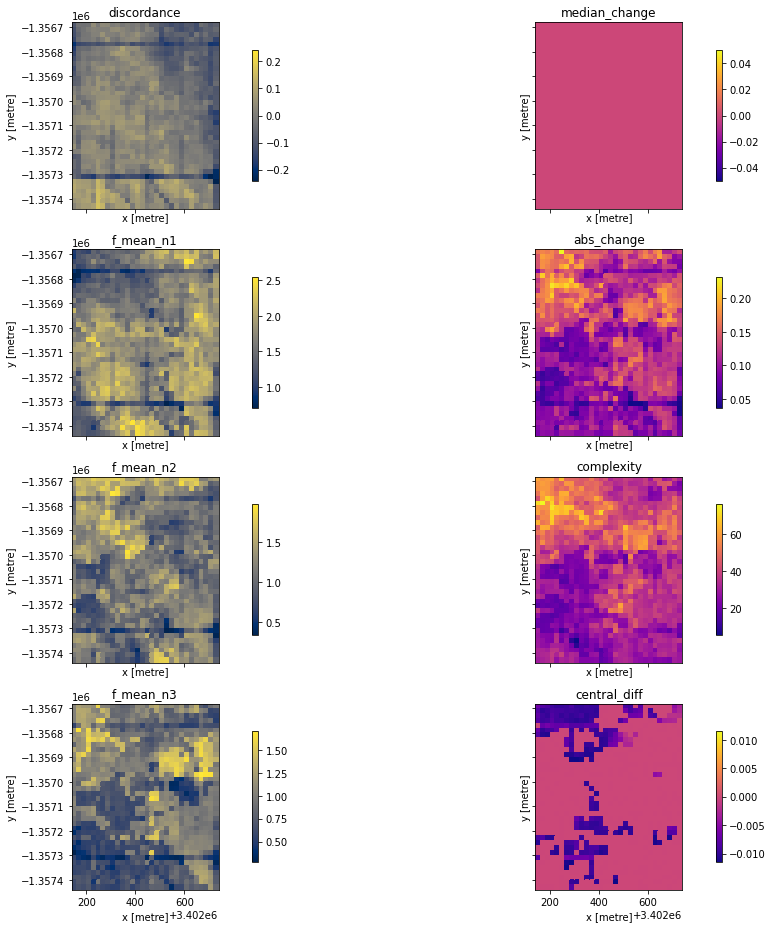

In [35]:
# set up figure
fig, axes = plt.subplots(nrows=4,
                       ncols=2,
                       figsize=(16, 13),
                       sharex=True,
                       sharey=True)

# set colorbar size
cbar_size = 0.5

# set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')
    
# set colorbar size
cbar_size = 0.7
stats = list(ts_stats.data_vars)

#plot
for ax,stat_1,stat_2 in zip(axes, stats[0:4], stats[4:8]):
    ts_stats[stat_1].plot(ax=ax[0],cmap='cividis',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)
    
    ts_stats[stat_2].plot(ax=ax[1],cmap='plasma',cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)

plt.tight_layout();

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and seasonality across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


## Next steps

When you're done, if you wish to run this code for another region, return to the "Analysis parameters" cell, modify some values (e.g. `time_range`,  or `lat`/`lon`) and rerun the analysis.

For advanced users, `xr_phenology` could be used for generating phenology feature layers in a machine learning classifier (see [Machine Learning with ODC](../Real_world_examples/Machine_learning_with_ODC.ipynb) for example of running ML models with ODC data).  `xr_phenology` can be passed inside of the `custom_func` parameter in the `deafrica_classificationtools.collect_training_data()` function, allowing phenological statistics to be computed during the collection of training data. An example would look like this:

    import sys
    sys.path.append('../Scripts')
    from deafrica_temporal_statistics import xr_phenology
    from deafrica_classificationtools import collect_training_data

    def phenology_stats(da):
        stats = xr_phenology(da, complete='fast_complete')
        return stats

    training = collect_training_data(...,
                                     custom_func=phenology_stats)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [36]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [37]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-06'